# Project: Stock Price Prediction

In [79]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

### Overall Goal

Predict stock price (high) on day X+1 as precisely as possible.

### Data Import And Cleaning

In [20]:
#get data

path_to_df = "..\Data\SPX.csv"
df = pd.read_csv(path_to_df)

df = df[::-1].reset_index(drop=True) #reverse order

df.head()

,Date,Close/Last,Open,High,Low
0,02/24/2014,1847.61,1836.78,1858.71,1836.78
1,02/25/2014,1845.12,1847.66,1852.91,1840.19
2,02/26/2014,1845.16,1845.79,1852.65,1840.66
3,02/27/2014,1854.29,1844.90,1854.53,1841.13
4,02/28/2014,1859.45,1855.12,1867.92,1847.67


In [21]:
def plot_chart(df, col): # Plotting the col against dates
    # Create a larger plot
    fig, ax = plt.subplots(figsize=(12, 6))
    num_args = len(col)

    for ind in range(num_args):
        ax.plot(df['Date'], df[col[ind]])

    ax.set_title('Plot of price over time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    # Automatically set the x-axis date labels based on available space
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout for better appearance
    plt.show() 

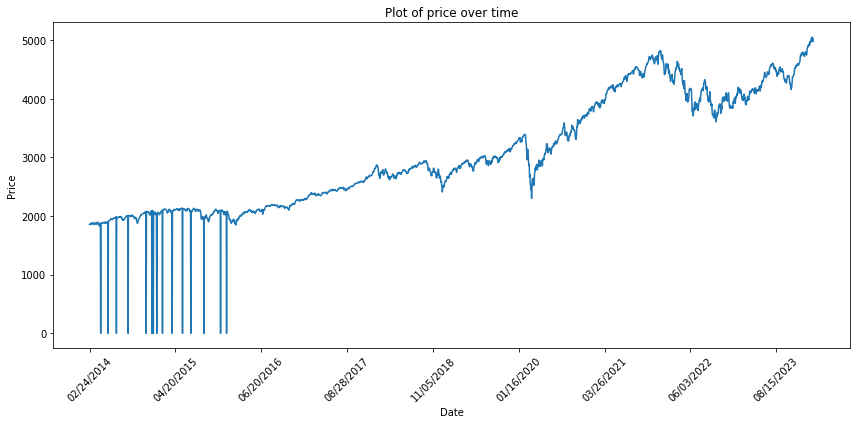

In [22]:
plot_chart(df, ["High"])

In [33]:
#remove data before june 2016
df['Date'] = pd.to_datetime(df['Date'])
df_filtered = df[df['Date'] >= '06/01/2016']
df_filtered = df_filtered.reset_index(drop=True)

df_filtered.head()

,Date,Close/Last,Open,High,Low
0,2016-06-01,2099.33,2093.94,2100.97,2085.10
1,2016-06-02,2105.26,2097.71,2105.26,2088.59
2,2016-06-03,2099.13,2104.07,2104.07,2085.36
3,2016-06-06,2109.41,2100.83,2113.36,2100.83
4,2016-06-07,2112.13,2110.18,2119.22,2110.18


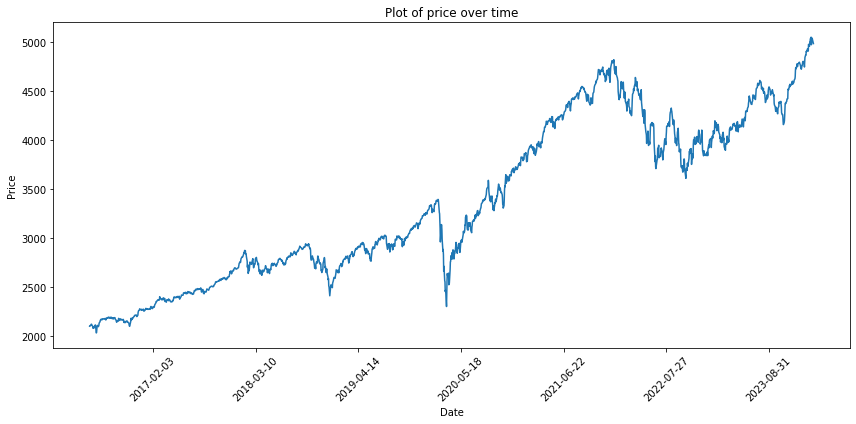

In [34]:
plot_chart(df_filtered, ["High"])

### 1. Linear Regression

In [25]:
#Technique 1: Linear Regression
#fit model to the last X (Hyperparam) days
#use model to predict price on day X+1
#eval

In [35]:
#fit model

def fit_lin_reg(X):
    model = LinearRegression()

    stock_prices = df_filtered["High"].values
    predicted_stock_prices = [0] * X

    for ind, _ in enumerate(stock_prices): #loop over daily highs
        if ind >= len(stock_prices) - X:
            break
        prices = stock_prices[ind:ind + X] #get X highs (label)
        days = np.arange(X).reshape(-1, 1) #X days (feature)
        model.fit(days, prices) #fit model to training examples
        y_pred = model.predict(np.array(X + 1).reshape(-1, 1)) #predict on day X+1
        predicted_stock_prices.append(round(y_pred[0], 2)) 

    predicted_stock_prices = np.array(predicted_stock_prices)
    df_filtered_ext = df_filtered.copy()
    df_filtered_ext["lin_reg_pred"] = predicted_stock_prices
    return df_filtered_ext

df_filtered_ext = fit_lin_reg(5)

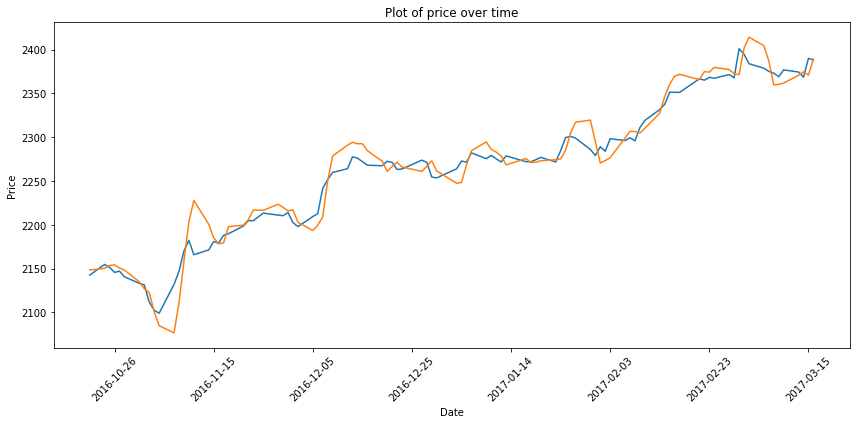

In [36]:
#plot
plot_chart(df_filtered_ext[100:200], ["High", "lin_reg_pred"])

In [37]:
#eval

#print(df_filtered_ext["High"][X:])
#print(df_filtered_ext["lin_reg_pred"][X:])
errors = []

for X in tqdm(range(1,20)):
    df_filtered_ext = fit_lin_reg(X)
    mse = np.mean((df_filtered_ext["High"][X:] - df_filtered_ext["lin_reg_pred"][X:]) ** 2)
    errors.append(mse)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


Lowest MSE is 960.7744060730826, with X=1 (just copies high from prev day)
Lowest MSE is 2472.6941750258, with non-trivial X=5


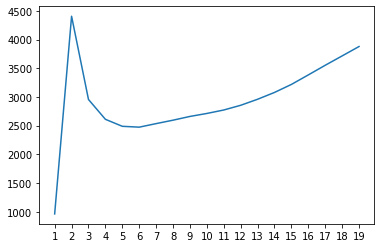

In [38]:
x_values = np.arange(1, len(errors) + 1)
plt.plot(x_values, errors)
plt.xticks(np.arange(1, len(errors) + 1, 1))

best_X, best_MSE = min(enumerate(errors), key=lambda x: x[1])
print(f"Lowest MSE is {best_MSE}, with X={best_X+1} (just copies high from prev day)")

errors_copy = errors.copy()

del errors_copy[best_X]

sec_best_X, sec_best_MSE = min(enumerate(errors_copy), key=lambda x: x[1])
print(f"Lowest MSE is {sec_best_MSE}, with non-trivial X={sec_best_X+1}")

Can I find a method that is better than just copying the value from the previous day?

### 2. Multilayer Perceptron

In [228]:
# prepare training data

def prep_data(feature_vec_len):
    features = []
    labels = []
    df_len = len(df_filtered_ext.values)


    for ind in range(df_len):
        feature_vec = []
        if ind < df_len - feature_vec_len:
            for ind2 in range(feature_vec_len):
                feature = df_filtered_ext.loc[ind + ind2]["High"]
                feature_vec.append(feature)

            label = df_filtered_ext.loc[ind + ind2 + 1]["High"]
            labels.append(label)
            features.append(feature_vec)

    features = np.array(features)
    labels = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=False)

    # Shuffle only the training set
    shuffle_indices = np.arange(len(X_train))
    np.random.shuffle(shuffle_indices)

    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]


    feature_scaler = StandardScaler()
    label_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)
    y_train_scaled = label_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = label_scaler.transform(y_test.reshape(-1, 1))
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, label_scaler


In [229]:
# init model

def create_model(feature_vec_len):
    model = Sequential()
    model.add(Dense(units=8, input_dim=feature_vec_len, activation='relu'))
    model.add(Dense(units=4, activation='relu'))
    model.add(Dense(units=1, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [235]:
# training

def train(model, X_train_scaled, y_train_scaled):
    history = model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=1, verbose=0)
    return history

In [231]:
# training loss plotting
def plot_training_loss(history):
    training_loss = history.history["loss"]
    plt.plot(training_loss)
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error Loss')
    plt.show()

In [232]:
# eval

def eval(model, label_scaler, X_test_scaled, y_test_scaled):
    y_pred_scaled = model.predict(X_test_scaled)

    y_pred = label_scaler.inverse_transform(y_pred_scaled)
    y_test = label_scaler.inverse_transform(y_test_scaled)
    mse = mean_squared_error(y_test, y_pred)

    return mse, y_test, y_pred

In [236]:
errors = []

for feat_vec_len in tqdm(range(1,25)):
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, label_scaler = prep_data(feat_vec_len)
    model = create_model(feat_vec_len)
    history = train(model, X_train_scaled, y_train_scaled)
    mse, y_test, y_pred = eval(model, label_scaler, X_test_scaled, y_test_scaled)
    errors.append(mse)    

  0%|          | 0/24 [00:00<?, ?it/s]

13/13 [==============================] - 0s 2ms/step


  4%|▍         | 1/24 [00:27<10:31, 27.47s/it]

13/13 [==============================] - 0s 2ms/step


  8%|▊         | 2/24 [00:54<09:59, 27.23s/it]

13/13 [==============================] - 0s 2ms/step


 12%|█▎        | 3/24 [01:23<09:45, 27.90s/it]

13/13 [==============================] - 0s 2ms/step


 17%|█▋        | 4/24 [01:52<09:25, 28.29s/it]

13/13 [==============================] - 0s 2ms/step


 21%|██        | 5/24 [02:21<09:07, 28.82s/it]

13/13 [==============================] - 0s 2ms/step


 25%|██▌       | 6/24 [02:51<08:46, 29.25s/it]

13/13 [==============================] - 0s 2ms/step


 29%|██▉       | 7/24 [03:23<08:28, 29.90s/it]

13/13 [==============================] - 0s 2ms/step


 33%|███▎      | 8/24 [03:54<08:04, 30.29s/it]

13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 9/24 [04:27<07:45, 31.05s/it]

13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 10/24 [05:00<07:23, 31.64s/it]

13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 11/24 [05:34<07:02, 32.47s/it]

13/13 [==============================] - 0s 2ms/step


 50%|█████     | 12/24 [06:08<06:37, 33.12s/it]

13/13 [==============================] - 0s 2ms/step


 54%|█████▍    | 13/24 [06:44<06:13, 33.93s/it]

13/13 [==============================] - 0s 2ms/step


 58%|█████▊    | 14/24 [07:20<05:45, 34.51s/it]

13/13 [==============================] - 0s 2ms/step


 62%|██████▎   | 15/24 [07:57<05:16, 35.14s/it]

13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 16/24 [08:34<04:47, 35.91s/it]

13/13 [==============================] - 0s 2ms/step


 71%|███████   | 17/24 [09:12<04:15, 36.45s/it]

13/13 [==============================] - 0s 5ms/step


 75%|███████▌  | 18/24 [09:51<03:42, 37.06s/it]

13/13 [==============================] - 0s 2ms/step


 79%|███████▉  | 19/24 [10:30<03:08, 37.76s/it]

13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 20/24 [11:10<02:33, 38.39s/it]

13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 21/24 [11:51<01:57, 39.15s/it]

13/13 [==============================] - 0s 2ms/step


 92%|█████████▏| 22/24 [12:33<01:20, 40.16s/it]

13/13 [==============================] - 0s 2ms/step


 96%|█████████▌| 23/24 [13:20<00:42, 42.05s/it]

12/12 [==============================] - 0s 2ms/step


100%|██████████| 24/24 [14:02<00:00, 35.12s/it]


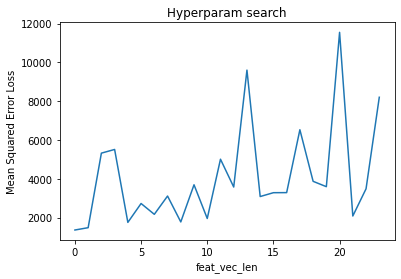

In [237]:
plt.plot(errors)
plt.title('Hyperparam search')
plt.xlabel('feat_vec_len')
plt.ylabel('Mean Squared Error Loss')
plt.show()    

In [ ]:
sec_best_X, sec_best_MSE = min(enumerate(errors), key=lambda x: x[1])
print(f"Lowest MSE is {sec_best_MSE}, with non-trivial X={sec_best_X+1}")

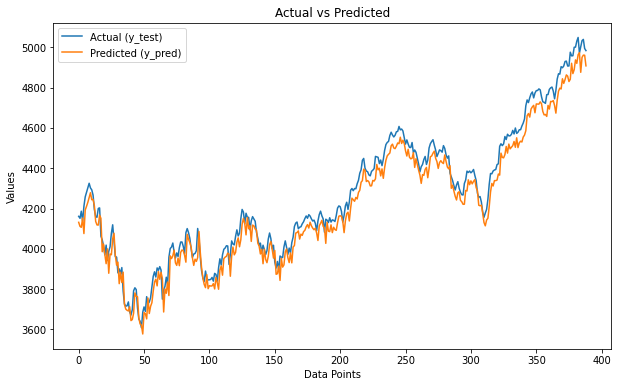

In [226]:
# Plot y_test and y_pred with a larger chart size
plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.plot(y_test, label='Actual (y_test)')
plt.plot(y_pred, label='Predicted (y_pred)')
plt.legend()
plt.title('Actual vs Predicted')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.show()